In [1]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import seaborn as sns
train = pd.read_csv('../data/spaceship_titanic_train.csv')
test = pd.read_csv('../data/spaceship_titanic_test.csv')

In [2]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from IPython import display

In [3]:
def prepare_data(data, do_1hot=True, X_only = False):
    group_count = lambda id_: id_[:4]
    data['travel_group'] = data['PassengerId'].apply(lambda id_: id_[:4])
    data['travel_group_n'] = data['travel_group'].apply(lambda group: data.loc[data.travel_group == group].shape[0])
    data['travelling_with_n_kids'] = (-1)*(train['Age'] < 18).astype(int)+ data['travel_group'].apply(lambda group: data.loc[(data.travel_group == group) & (data.Age < 18)].shape[0])
    data['cabin_side'] = data.Cabin.apply(lambda cabin: np.nan if str(cabin) == 'nan' else str(cabin)[-1])
    data['cabin_deck'] = data.Cabin.apply(lambda cabin: np.nan if str(cabin) == 'nan' else str(cabin)[0])
    data['cabin_num'] = data.Cabin.apply(lambda cabin: np.nan if str(cabin) == 'nan' else int(str(cabin)[2:-2]))
    
    
    drop_ = ['PassengerId','Name', 'Cabin', 'travel_group']
    if not X_only:
        cat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'cabin_side', 'cabin_deck']
    else:
        cat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'cabin_side', 'cabin_deck']
    num = ['FoodCourt', 'VRDeck', 'Spa', 'Age', 'RoomService', 'ShoppingMall', 'cabin_num']
    one_hot = OneHotEncoder(sparse_output=False, drop='if_binary')
   
    if do_1hot:
        pipe = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        one_hot)
    else:
        pipe = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OrdinalEncoder())
    
    transformer = ColumnTransformer([
        ('cat', pipe, cat),
        ('num', SimpleImputer(strategy='mean'), num),
        ('drop_', 'drop', drop_)
    ], remainder='passthrough',
       verbose_feature_names_out=False)

    
    d = transformer.fit_transform(data)
    if do_1hot:
        df = pd.DataFrame(d, columns = transformer.get_feature_names_out(), dtype=float)
    else:
        df = pd.DataFrame(d, columns = transformer.get_feature_names_out())
    return df

In [4]:
train_prep = prepare_data(train, do_1hot = True, X_only=False)
train_X, train_y = train_prep.drop('Transported_True', axis=1), train_prep.Transported_True

In [5]:
xgb_params = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 4,
    "random_seed": 1,
    "eval_metric": "error",
    #train-error-mean    0.861325
    #test-error-mean     0.810883
    
    #eta = 0.01 test 0.78, train 80.5
    
    # regularization parameters
    "max_depth": 5,
    "max_leaves": 0,
    "min_child_weight":1,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "n_estimators": 10_000
    
    #train-error-mean    0.848240
    #test-error-mean     0.811689
    
#    "tree_method": "hist",    
#    "grow_policy": "lossguide"
#     train-error-mean    0.827677
#     test-error-mean     0.807776
}
xgb_train = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=127)
result = xgb.cv(xgb_params, xgb_train, folds =skf, num_boost_round=10_000, early_stopping_rounds=10, verbose_eval=10)
xgb_params['n_estimators'] = list(result['test-error-mean']).index(min(list(result['test-error-mean'])))
1-result.iloc[-1, [0, 2]]

[0]	train-error:0.24140+0.00109	test-error:0.25020+0.00579
[10]	train-error:0.18981+0.00140	test-error:0.20821+0.00452
[20]	train-error:0.18115+0.00137	test-error:0.20246+0.00477
[30]	train-error:0.17169+0.00144	test-error:0.19591+0.00383
[40]	train-error:0.16620+0.00193	test-error:0.19360+0.00493
[50]	train-error:0.16125+0.00164	test-error:0.19096+0.00499
[60]	train-error:0.15383+0.00171	test-error:0.19038+0.00750
[70]	train-error:0.14960+0.00188	test-error:0.18946+0.00611
[73]	train-error:0.14857+0.00175	test-error:0.18935+0.00643


train-error-mean    0.848240
test-error-mean     0.811689
Name: 64, dtype: float64

In [8]:
xgb_clf = xgb.XGBClassifier(**xgb_params)
xgb_clf.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='error',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=73, n_jobs=None,
              nthread=4, num_parallel_tree=None, ...)

In [9]:
import shap

explainer = shap.TreeExplainer(xgb_clf, train_X, model_output="probability")

In [28]:
shap.initjs()
shap_values = explainer.shap_values(train_X)
shap.force_plot(explainer.expected_value, shap_values[10,:], train_X.iloc[10,:])

 98%|===================| 8534/8693 [00:12<00:00]        

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:10], train_X.iloc[:10,:])

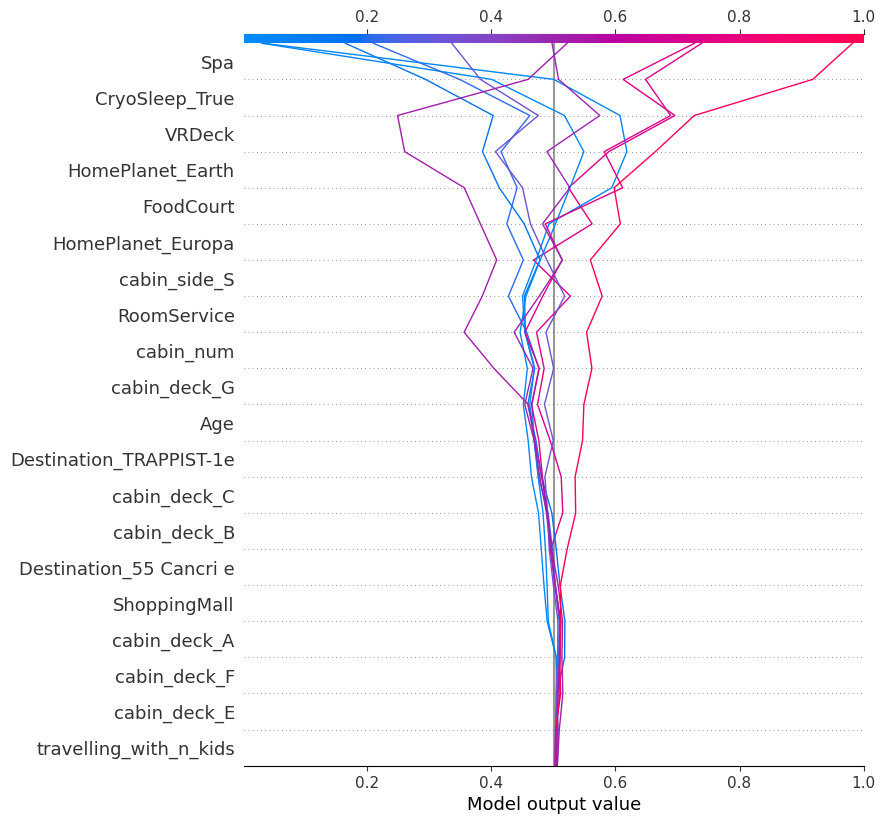

In [11]:
shap.decision_plot(explainer.expected_value, shap_values[:10, :], feature_names=list(train_X.columns))

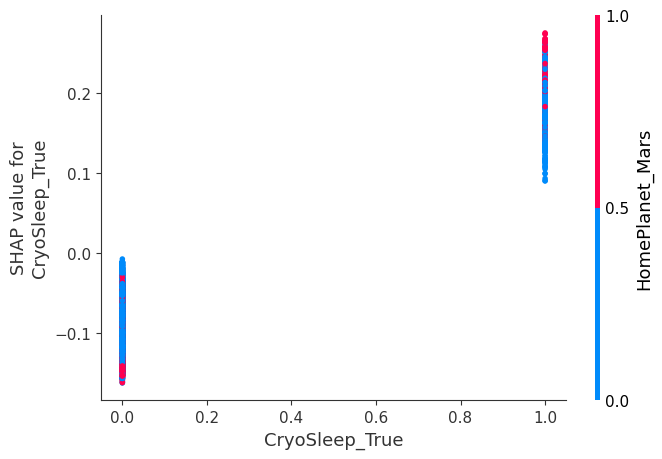

In [14]:
shap.dependence_plot("CryoSleep_True", shap_values, train_X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


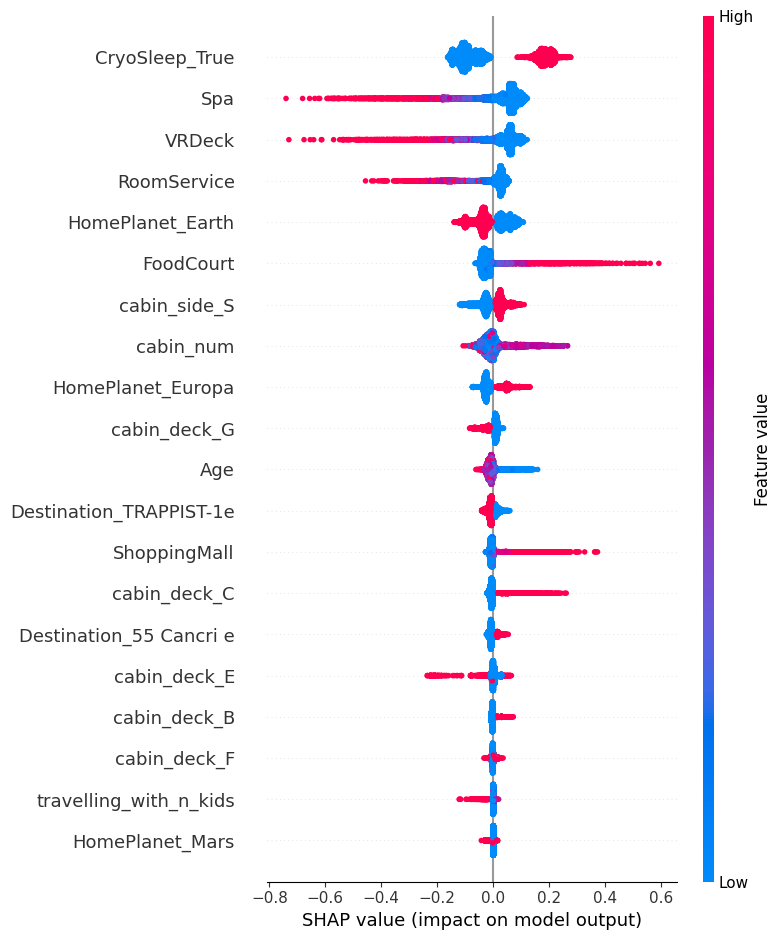

In [12]:
shap.summary_plot(shap_values, train_X)

* 1. Passengers, who chose to spend their travel in Cryosleep, much more likely were transported to another dimention.
* 2. Passengers, who spent a lot of money on spa, VRDeck and room service, most likely weren't transported.
* 3. Passengers, who spent a lot of money at the food court or shopping mall, are more prone to transportation.
* 4. Passengers from Earth are less likely to be transported, whereas passengers from Europe are in more danger.
* 5. People, who were staying on deck E or/and Port side, were in less danger than those who lived on deck C or/and Starboard side.
* 6. Young people were a little more likely to be transported.

Although LIME interpretations contradict with SHAP ones when it comes to spa, room service and home planet Earth. In some cases those features increase score, in others - they decrease it. According to LIME, even Cryosleep can drastically decrease score, which doesn't make sense. I would rely more on SHAP interpretation.

In [22]:
from eli5 import show_weights, explain_prediction
show_weights(xgb_clf, top=5)

In [37]:
explain_prediction(xgb_clf, train_X.iloc[6])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=64, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='FoodCourt', weight=0.6477628433105607, std=None, value=1539.0), FeatureWeight(feature='VRDeck', weight=0.5489736577365035, std=None, value=0.0), FeatureWeight(feature='Spa', weight=0.3604151266119666, std=None, value=0.0), FeatureWeight(feature='RoomService', weight=0.3483437627264158, std=None, value=42.0), FeatureWeight(feature='cabin_side_S', weight=0.17317408490676817, std=None, value=1.0), FeatureWeight(feature='cabin_deck_G', weight=0.0391722454719869, std=None, value=0.0), FeatureWeight(feature='<BIAS>', weight=0.019130435946518972, std=None, value=1.0), FeatureWeight(feature='travel_group_n', weight=0.01394060626895191, std=None, value=2.0), FeatureWeight(feature='HomePlanet_Mars', weight=0.00871753279577412, std=None, value=0.0), FeatureWeight(feature='travelling_with_n_kids', weight=0.007676406091274636, std=None, value=0.0), FeatureWeight(feature='cabin_deck_F', weight=0.0067636059995679725, std=None, value=1.0)], neg=[FeatureWeight(feature='CryoSleep_True', weight=-0.6119750969439668, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Europa', weight=-0.11615473608375615, std=None, value=0.0), FeatureWeight(feature='cabin_num', weight=-0.09332140722829063, std=None, value=2.0), FeatureWeight(feature='HomePlanet_Earth', weight=-0.08488826979778627, std=None, value=1.0), FeatureWeight(feature='ShoppingMall', weight=-0.05720164133758986, std=None, value=3.0), FeatureWeight(feature='Age', weight=-0.05003439403683763, std=None, value=26.0), FeatureWeight(feature='cabin_deck_C', weight=-0.045413659367504265, std=None, value=0.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=-0.025359709524081765, std=None, value=1.0), FeatureWeight(feature='Destination_55 Cancri e', weight=-0.02489901700117221, std=None, value=0.0), FeatureWeight(feature='cabin_deck_B', weight=-0.023704529245303436, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.73906565, score=1.0411178473000005, weighted_spans=None, heatmap

In [32]:
explain_prediction(xgb_clf, train_X.iloc[12])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=64, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='CryoSleep_True', weight=0.6582188226082102, std=None, value=0.0), FeatureWeight(feature='cabin_side_S', weight=0.1818448611151074, std=None, value=0.0), FeatureWeight(feature='FoodCourt', weight=0.18052108363509176, std=None, value=0.0), FeatureWeight(feature='cabin_num', weight=0.13633247539247462, std=None, value=1.0), FeatureWeight(feature='HomePlanet_Europa', weight=0.1027871229686712, std=None, value=0.0), FeatureWeight(feature='Age', weight=0.07659834030026955, std=None, value=32.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=0.0368240714504565, std=None, value=1.0), FeatureWeight(feature='HomePlanet_Mars', weight=0.02236646418425063, std=None, value=1.0), FeatureWeight(feature='cabin_deck_C', weight=0.018371891202557458, std=None, value=0.0), FeatureWeight(feature='Destination_55 Cancri e', weight=0.01661326037602854, std=None, value=0.0), FeatureWeight(feature='VRDeck', weight=0.009515879184160463, std=None, value=113.0), FeatureWeight(feature='cabin_deck_B', weight=0.003924663135835905, std=None, value=0.0)], neg=[FeatureWeight(feature='Spa', weight=-0.34202598566668135, std=None, value=0.0), FeatureWeight(feature='RoomService', weight=-0.3013789610195517, std=None, value=73.0), FeatureWeight(feature='ShoppingMall', weight=-0.21059523592561052, std=None, value=1123.0), FeatureWeight(feature='HomePlanet_Earth', weight=-0.2027952036746749, std=None, value=0.0), FeatureWeight(feature='cabin_deck_E', weight=-0.09393218364625185, std=None, value=0.0), FeatureWeight(feature='cabin_deck_F', weight=-0.04185273537767617, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.019130435946518972, std=None, value=1.0), FeatureWeight(feature='cabin_deck_G', weight=-0.009816312224647919, std=None, value=0.0), FeatureWeight(feature='travel_group_n', weight=-0.009561768417897264, std=None, value=1.0), FeatureWeight(feature='travelling_with_n_kids', weight=-0.007676406091274636, std=None, value=0.0), FeatureWeight(feat

Середній імпакт:

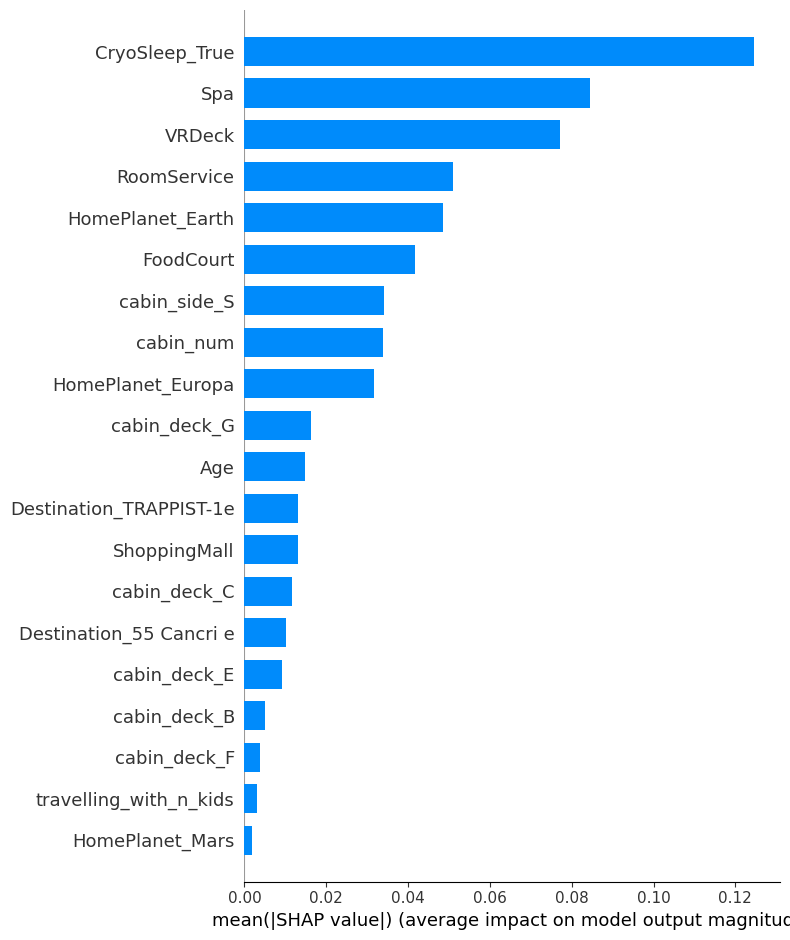

In [21]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

Чи співпадає інтерпретація eli5, shap?

In [55]:
import random
r = [random.randint(0, 8693) for i in range(5)]
print(r)

[7761, 4716, 4962, 4316, 5626]


## 1.

In [56]:
explain_prediction(xgb_clf, train_X.iloc[r[0]])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=73, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='CryoSleep_True', weight=0.6698808891048792, std=None, value=0.0), FeatureWeight(feature='Spa', weight=0.6689444455144021, std=None, value=453.0), FeatureWeight(feature='ShoppingMall', weight=0.3156413383121292, std=None, value=233.0), FeatureWeight(feature='FoodCourt', weight=0.26755442014603337, std=None, value=1.0), FeatureWeight(feature='cabin_side_S', weight=0.2574273678377079, std=None, value=0.0), FeatureWeight(feature='cabin_num', weight=0.22023538707284315, std=None, value=1704.0), FeatureWeight(feature='Age', weight=0.0467652414012608, std=None, value=45.0), FeatureWeight(feature='cabin_deck_C', weight=0.04567003483964525, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Earth', weight=0.03305696032859483, std=None, value=1.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=0.028528386329774197, std=None, value=1.0), FeatureWeight(feature='HomePlanet_Europa', weight=0.027887492803229927, std=None, value=0.0), FeatureWeight(feature='Destination_55 Cancri e', weight=0.011724119261992468, std=None, value=0.0), FeatureWeight(feature='cabin_deck_E', weight=0.004137188359114788, std=None, value=0.0), FeatureWeight(feature='cabin_deck_B', weight=0.003924663135835905, std=None, value=0.0)], neg=[FeatureWeight(feature='RoomService', weight=-0.10775749554582102, std=None, value=0.0), FeatureWeight(feature='VRDeck', weight=-0.08093003569593171, std=None, value=17.0), FeatureWeight(feature='cabin_deck_F', weight=-0.04266491507123536, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.01901901203131193, std=None, value=1.0), FeatureWeight(feature='travel_group_n', weight=-0.009561768417897264, std=None, value=1.0), FeatureWeight(feature='cabin_deck_G', weight=-0.005616335892459512, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Mars', weight=-0.004478592149413165, std=None, value=0.0), FeatureWeight(feature='travelling_with_n_kids', weight=-0.003872763460973188, std=None, value=0.0)], pos_remaining=

In [57]:
pd.Series(shap_values[r[0]], index=train_X.columns).sort_values(ascending=False)

RoomService                  0.014097
cabin_deck_G                 0.007478
cabin_deck_F                 0.006007
VRDeck                       0.004556
HomePlanet_Mars              0.001167
travelling_with_n_kids       0.000599
cabin_deck_A                 0.000238
travel_group_n               0.000024
cabin_deck_T                 0.000000
cabin_deck_D                -0.000030
Destination_PSO J318.5-22   -0.000046
VIP_True                    -0.000047
cabin_deck_E                -0.001168
cabin_deck_B                -0.001808
Destination_55 Cancri e     -0.006046
cabin_deck_C                -0.006668
Destination_TRAPPIST-1e     -0.007579
Age                         -0.011963
ShoppingMall                -0.015867
HomePlanet_Europa           -0.017556
cabin_side_S                -0.027460
FoodCourt                   -0.034409
HomePlanet_Earth            -0.040458
cabin_num                   -0.045727
CryoSleep_True              -0.099639
Spa                         -0.130598
dtype: float

## 2.

In [58]:
explain_prediction(xgb_clf, train_X.iloc[r[1]])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=73, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='VRDeck', weight=3.110145511886134, std=None, value=4160.0), FeatureWeight(feature='CryoSleep_True', weight=0.622121579995689, std=None, value=0.0), FeatureWeight(feature='FoodCourt', weight=0.44113210715656415, std=None, value=52.0), FeatureWeight(feature='ShoppingMall', weight=0.08111255588456229, std=None, value=8.0), FeatureWeight(feature='travel_group_n', weight=0.05883467147874406, std=None, value=1.0), FeatureWeight(feature='cabin_deck_C', weight=0.05241977726296508, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Europa', weight=0.024644157586152748, std=None, value=0.0), FeatureWeight(feature='Destination_55 Cancri e', weight=0.016549027222474987, std=None, value=0.0), FeatureWeight(feature='cabin_deck_E', weight=0.013731289424170913, std=None, value=0.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=0.006433322971605761, std=None, value=1.0), FeatureWeight(feature='Age', weight=0.0045398181329083685, std=None, value=36.0)], neg=[FeatureWeight(feature='cabin_num', weight=-0.587267784906607, std=None, value=824.0), FeatureWeight(feature='Spa', weight=-0.4378112759427372, std=None, value=0.0), FeatureWeight(feature='RoomService', weight=-0.3383160998157525, std=None, value=0.0), FeatureWeight(feature='cabin_side_S', weight=-0.16577717576560755, std=None, value=1.0), FeatureWeight(feature='cabin_deck_F', weight=-0.059673974763555786, std=None, value=0.0), FeatureWeight(feature='<BIAS>', weight=-0.01901901203131193, std=None, value=1.0), FeatureWeight(feature='HomePlanet_Earth', weight=-0.005845238145486209, std=None, value=1.0), FeatureWeight(feature='travelling_with_n_kids', weight=-0.005074297736947001, std=None, value=0.0), FeatureWeight(feature='VIP_True', weight=-0.0005691062239668648, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.9433374, score=-2.8123098536700004, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_fea

In [59]:
pd.Series(shap_values[r[1]], index=train_X.columns).sort_values(ascending=False)

cabin_num                    9.255423e-02
cabin_side_S                 5.197985e-02
Spa                          2.975514e-02
RoomService                  1.054351e-02
cabin_deck_F                 1.193236e-03
travelling_with_n_kids       9.096611e-04
cabin_deck_E                 4.725877e-04
cabin_deck_A                 2.199106e-04
HomePlanet_Mars              1.136036e-04
VIP_True                     3.255451e-06
cabin_deck_D                 4.958276e-08
cabin_deck_T                 0.000000e+00
Destination_PSO J318.5-22   -1.407696e-04
cabin_deck_B                -2.086104e-03
travel_group_n              -2.572887e-03
ShoppingMall                -5.211698e-03
cabin_deck_C                -6.005381e-03
Destination_TRAPPIST-1e     -6.477529e-03
Destination_55 Cancri e     -7.943275e-03
cabin_deck_G                -8.950357e-03
Age                         -1.164712e-02
HomePlanet_Europa           -1.404193e-02
FoodCourt                   -2.414237e-02
HomePlanet_Earth            -2.553

## 3.

In [60]:
explain_prediction(xgb_clf, train_X.iloc[r[2]])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=73, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='FoodCourt', weight=1.6862565365053237, std=None, value=4313.0), FeatureWeight(feature='cabin_deck_C', weight=0.9368697571864517, std=None, value=1.0), FeatureWeight(feature='VRDeck', weight=0.6653314425086003, std=None, value=60.0), FeatureWeight(feature='HomePlanet_Europa', weight=0.560508921883165, std=None, value=1.0), FeatureWeight(feature='cabin_side_S', weight=0.3976089104519289, std=None, value=1.0), FeatureWeight(feature='RoomService', weight=0.3567386770788364, std=None, value=0.0), FeatureWeight(feature='Spa', weight=0.2218309901830441, std=None, value=175.0), FeatureWeight(feature='HomePlanet_Earth', weight=0.14706803011981195, std=None, value=0.0), FeatureWeight(feature='cabin_num', weight=0.12060257345132146, std=None, value=206.0), FeatureWeight(feature='cabin_deck_E', weight=0.05178911907166237, std=None, value=0.0), FeatureWeight(feature='cabin_deck_A', weight=0.05103686688827322, std=None, value=0.0), FeatureWeight(feature='cabin_deck_G', weight=0.03359282718287613, std=None, value=0.0), FeatureWeight(feature='<BIAS>', weight=0.01901901203131193, std=None, value=1.0), FeatureWeight(feature='travelling_with_n_kids', weight=0.01574992814889313, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Mars', weight=0.004478592149413165, std=None, value=0.0)], neg=[FeatureWeight(feature='CryoSleep_True', weight=-0.6197116309794469, std=None, value=0.0), FeatureWeight(feature='Age', weight=-0.054967443809026975, std=None, value=25.0), FeatureWeight(feature='ShoppingMall', weight=-0.02004852797569816, std=None, value=0.0), FeatureWeight(feature='Destination_55 Cancri e', weight=-0.018224259237587186, std=None, value=0.0), FeatureWeight(feature='travel_group_n', weight=-0.015160149869331702, std=None, value=1.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=-0.01316449934381905, std=None, value=1.0), FeatureWeight(feature='cabin_deck_B', weight=-0.0010667611604036876, std=None, value=0.0)], pos_remaining=0, neg_r

In [61]:
pd.Series(shap_values[r[2]], index=train_X.columns).sort_values(ascending=False)

FoodCourt                    0.200572
cabin_deck_C                 0.077340
HomePlanet_Europa            0.051383
cabin_side_S                 0.043599
VRDeck                       0.035018
Spa                          0.031287
RoomService                  0.026506
HomePlanet_Earth             0.022274
cabin_num                    0.015201
cabin_deck_G                 0.006848
cabin_deck_E                 0.002683
travelling_with_n_kids       0.000995
cabin_deck_A                 0.000715
HomePlanet_Mars              0.000655
cabin_deck_F                 0.000117
cabin_deck_D                 0.000105
cabin_deck_T                 0.000000
VIP_True                    -0.000056
Destination_PSO J318.5-22   -0.000080
travel_group_n              -0.000416
cabin_deck_B                -0.001137
ShoppingMall                -0.002179
Destination_55 Cancri e     -0.002388
Destination_TRAPPIST-1e     -0.004009
Age                         -0.005462
CryoSleep_True              -0.012056
dtype: float

## 4.

In [62]:
explain_prediction(xgb_clf, train_X.iloc[r[3]])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=73, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='CryoSleep_True', weight=1.344491286959252, std=None, value=1.0), FeatureWeight(feature='cabin_num', weight=0.17707301327828354, std=None, value=748.0), FeatureWeight(feature='Spa', weight=0.15762780361642187, std=None, value=0.0), FeatureWeight(feature='RoomService', weight=0.1235842742551784, std=None, value=0.0), FeatureWeight(feature='VRDeck', weight=0.11365305751496513, std=None, value=0.0), FeatureWeight(feature='travelling_with_n_kids', weight=0.021274554923999878, std=None, value=0.0), FeatureWeight(feature='<BIAS>', weight=0.01901901203131193, std=None, value=1.0), FeatureWeight(feature='travel_group_n', weight=0.00496584786433893, std=None, value=1.0), FeatureWeight(feature='VIP_True', weight=0.0005691062239668648, std=None, value=0.0)], neg=[FeatureWeight(feature='HomePlanet_Earth', weight=-0.6541780672365064, std=None, value=1.0), FeatureWeight(feature='cabin_side_S', weight=-0.4693250527698354, std=None, value=0.0), FeatureWeight(feature='cabin_deck_G', weight=-0.18335532130781684, std=None, value=1.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=-0.16440430337919767, std=None, value=1.0), FeatureWeight(feature='Destination_55 Cancri e', weight=-0.06566545397002309, std=None, value=0.0), FeatureWeight(feature='Age', weight=-0.05228708008689193, std=None, value=32.0), FeatureWeight(feature='cabin_deck_F', weight=-0.05134987175991427, std=None, value=0.0), FeatureWeight(feature='FoodCourt', weight=-0.05134771697536889, std=None, value=0.0), FeatureWeight(feature='ShoppingMall', weight=-0.05123536609819563, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Europa', weight=-0.04697388869948743, std=None, value=0.0), FeatureWeight(feature='cabin_deck_C', weight=-0.007111650258045226, std=None, value=0.0), FeatureWeight(feature='cabin_deck_B', weight=-0.003924663135835905, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.540188, score=0.1610995209905999, weighted_spans=None, heatmap=None)], f

In [63]:
pd.Series(shap_values[r[3]], index=train_X.columns).sort_values(ascending=False)

CryoSleep_True               0.186207
Spa                          0.081183
VRDeck                       0.061200
RoomService                  0.031137
cabin_num                    0.025889
cabin_deck_E                 0.006091
travelling_with_n_kids       0.002089
HomePlanet_Mars              0.000865
cabin_deck_A                 0.000735
cabin_deck_D                 0.000019
cabin_deck_T                 0.000000
VIP_True                    -0.000015
Destination_PSO J318.5-22   -0.000125
travel_group_n              -0.000575
cabin_deck_B                -0.002271
cabin_deck_C                -0.004312
ShoppingMall                -0.009064
cabin_deck_F                -0.009402
Age                         -0.012555
Destination_55 Cancri e     -0.015018
HomePlanet_Europa           -0.024107
Destination_TRAPPIST-1e     -0.024369
FoodCourt                   -0.032906
cabin_deck_G                -0.041293
cabin_side_S                -0.080438
HomePlanet_Earth            -0.100555
dtype: float

## 5.

In [64]:
explain_prediction(xgb_clf, train_X.iloc[r[4]])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=73, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='RoomService', weight=1.377599327172806, std=None, value=1442.0), FeatureWeight(feature='CryoSleep_True', weight=0.6659553566436903, std=None, value=0.0), FeatureWeight(feature='Age', weight=0.2387739707156826, std=None, value=25.0), FeatureWeight(feature='FoodCourt', weight=0.15801079732631623, std=None, value=0.0), FeatureWeight(feature='cabin_side_S', weight=0.15572096519137812, std=None, value=0.0), FeatureWeight(feature='ShoppingMall', weight=0.13244710530687703, std=None, value=0.0), FeatureWeight(feature='VIP_True', weight=0.05015211572671785, std=None, value=1.0), FeatureWeight(feature='HomePlanet_Europa', weight=0.04030728779016191, std=None, value=0.0), FeatureWeight(feature='VRDeck', weight=0.03776224713946357, std=None, value=13.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=0.03507654582189107, std=None, value=1.0), FeatureWeight(feature='Destination_PSO J318.5-22', weight=0.02424129664556482, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Mars', weight=0.02236646418425063, std=None, value=1.0), FeatureWeight(feature='Destination_55 Cancri e', weight=0.011724119261992468, std=None, value=0.0), FeatureWeight(feature='cabin_deck_C', weight=0.005646970885440425, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Earth', weight=0.00448499264811375, std=None, value=0.0), FeatureWeight(feature='cabin_deck_E', weight=0.004137188359114788, std=None, value=0.0), FeatureWeight(feature='cabin_deck_B', weight=0.003924663135835905, std=None, value=0.0)], neg=[FeatureWeight(feature='Spa', weight=-0.3129335396459951, std=None, value=0.0), FeatureWeight(feature='cabin_num', weight=-0.07858460031184943, std=None, value=1233.0), FeatureWeight(feature='cabin_deck_F', weight=-0.04266491507123536, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.01901901203131193, std=None, value=1.0), FeatureWeight(feature='travel_group_n', weight=-0.013446647036727735, std=None, value=2.0), FeatureWeight(feature='t

In [65]:
pd.Series(shap_values[r[4]], index=train_X.columns).sort_values(ascending=False)

Spa                          0.033563
HomePlanet_Earth             0.031508
cabin_deck_F                 0.007147
cabin_deck_G                 0.006452
VRDeck                       0.003501
cabin_deck_E                 0.001682
travelling_with_n_kids       0.000814
cabin_deck_A                 0.000357
HomePlanet_Mars              0.000015
cabin_deck_T                 0.000000
cabin_deck_D                -0.000021
travel_group_n              -0.000439
VIP_True                    -0.000680
cabin_deck_B                -0.001523
cabin_num                   -0.001762
Destination_PSO J318.5-22   -0.002205
ShoppingMall                -0.003542
cabin_deck_C                -0.003961
Destination_55 Cancri e     -0.007747
Destination_TRAPPIST-1e     -0.010772
cabin_side_S                -0.021448
HomePlanet_Europa           -0.023669
Age                         -0.031750
FoodCourt                   -0.032671
CryoSleep_True              -0.145839
RoomService                 -0.223042
dtype: float

## 6.

In [66]:
explain_prediction(xgb_clf, train_X.iloc[1009])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=73, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='VRDeck', weight=0.5168186188072191, std=None, value=0.0), FeatureWeight(feature='Spa', weight=0.3847998619589278, std=None, value=0.0), FeatureWeight(feature='cabin_deck_E', weight=0.3565442681810452, std=None, value=1.0), FeatureWeight(feature='RoomService', weight=0.3140606908533639, std=None, value=79.0), FeatureWeight(feature='Destination_55 Cancri e', weight=0.18042715257865205, std=None, value=1.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=0.11382495799832025, std=None, value=0.0), FeatureWeight(feature='cabin_deck_G', weight=0.05113846784974102, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Mars', weight=0.04163764731010936, std=None, value=0.0), FeatureWeight(feature='cabin_num', weight=0.032332713720123904, std=None, value=60.0), FeatureWeight(feature='<BIAS>', weight=0.01901901203131193, std=None, value=1.0), FeatureWeight(feature='travelling_with_n_kids', weight=0.006215281115603268, std=None, value=0.0), FeatureWeight(feature='VIP_True', weight=0.0005691062239668648, std=None, value=0.0)], neg=[FeatureWeight(feature='CryoSleep_True', weight=-0.6281059057164341, std=None, value=0.0), FeatureWeight(feature='cabin_side_S', weight=-0.18041449238716048, std=None, value=0.0), FeatureWeight(feature='ShoppingMall', weight=-0.12571745186319822, std=None, value=0.0), FeatureWeight(feature='Age', weight=-0.10796227125062961, std=None, value=25.0), FeatureWeight(feature='HomePlanet_Europa', weight=-0.09257498566454697, std=None, value=0.0), FeatureWeight(feature='FoodCourt', weight=-0.027383671730405228, std=None, value=709.0), FeatureWeight(feature='HomePlanet_Earth', weight=-0.026354672773698046, std=None, value=1.0), FeatureWeight(feature='cabin_deck_C', weight=-0.007111650258045226, std=None, value=0.0), FeatureWeight(feature='cabin_deck_B', weight=-0.003924663135835905, std=None, value=0.0), FeatureWeight(feature='cabin_deck_F', weight=-0.0011735694678306364, std=None, value=0.0)], pos_remaining=0, neg_

In [67]:
pd.Series(shap_values[1009], index=train_X.columns).sort_values(ascending=False)

Spa                          0.099577
VRDeck                       0.097641
Destination_TRAPPIST-1e      0.036593
RoomService                  0.031177
Destination_55 Cancri e      0.028791
cabin_deck_E                 0.022128
cabin_deck_G                 0.016319
cabin_num                    0.004530
HomePlanet_Mars              0.002414
travelling_with_n_kids       0.001681
FoodCourt                    0.001506
cabin_deck_A                 0.000829
cabin_deck_F                 0.000239
VIP_True                     0.000120
cabin_deck_D                 0.000016
cabin_deck_T                 0.000000
travel_group_n              -0.000130
Destination_PSO J318.5-22   -0.000465
cabin_deck_B                -0.001801
cabin_deck_C                -0.004661
HomePlanet_Earth            -0.006366
ShoppingMall                -0.008273
Age                         -0.018349
HomePlanet_Europa           -0.026566
cabin_side_S                -0.028089
CryoSleep_True              -0.057111
dtype: float